Downloading/Loading MovieLens dataset...
Loaded 9742 real items from MovieLens.
Generating 1000 candidate slates...
Optimizing...


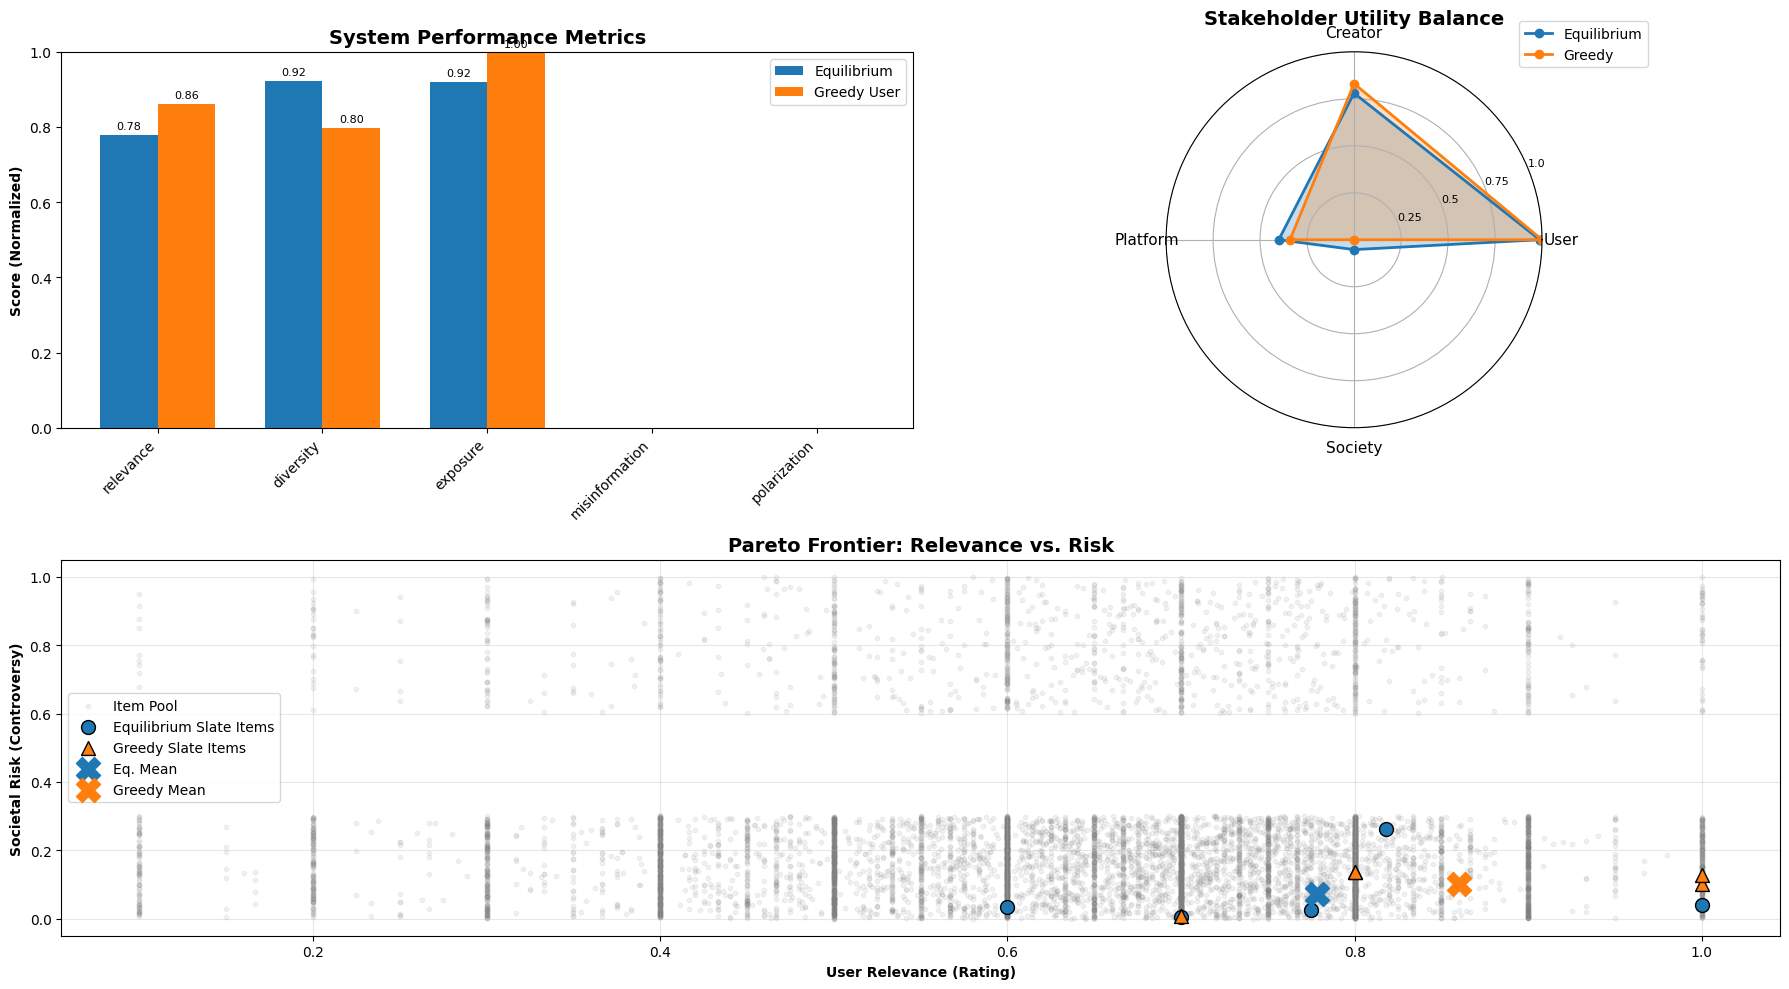


 BENCHMARK REPORT
Metric          | Equilibrium | Greedy User
----------------------------------------
Relevance       | 0.7786     | 0.8600
Diversity       | 0.9217     | 0.7967
Exposure        | 0.9188     | 0.9970
Misinformation  | 0.0728     | 0.1018
Polarization    | 0.0583     | 0.0814
----------------------------------------

Stakeholder Utilities (Raw Score):
  User        : Eq=1.239, Greedy=1.258
  Creator     : Eq=0.919, Greedy=0.997
  Platform    : Eq=0.333, Greedy=0.241
  Society     : Eq=-0.204, Greedy=-0.285


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from typing import Dict, List
import os
import requests
import zipfile
import io

# --- Configuration ---
SLATE_SIZE = 5
N_CANDIDATE_SLATES = 1000
# URL for MovieLens Small Dataset
MOVIELENS_URL = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"

# --- 1. Data Loading & Preprocessing ---
def load_real_data():
    """
    Loads MovieLens data. If download fails, falls back to generated data.
    Calculates popularity (exposure) and assigns synthetic controversy scores.
    """
    print("Downloading/Loading MovieLens dataset...")
    try:
        # Download and unzip
        r = requests.get(MOVIELENS_URL, timeout=10)
        r.raise_for_status()
        z = zipfile.ZipFile(io.BytesIO(r.content))

        # Read CSVs
        movies = pd.read_csv(z.open('ml-latest-small/movies.csv'))
        ratings = pd.read_csv(z.open('ml-latest-small/ratings.csv'))

        # Calculate Popularity (Exposure potential)
        # We define popularity as the number of ratings an item has received
        item_stats = ratings.groupby('movieId').agg(
            avg_rating=('rating', 'mean'),
            rating_count=('rating', 'count')
        ).reset_index()

        # Merge movies with stats
        df = movies.merge(item_stats, on='movieId', how='left')
        df['avg_rating'] = df['avg_rating'].fillna(2.5) # Fallback for unseen
        df['rating_count'] = df['rating_count'].fillna(0)

        # Normalize popularity for 'Exposure' calculation (0 to 1)
        max_pop = df['rating_count'].max()
        df['popularity_norm'] = df['rating_count'] / (max_pop + 1)

        # --- SIMULATE SOCIETAL METRICS ---
        # MovieLens has no 'misinformation' tag. We simulate 'controversy' (0 to 1)
        # assuming random movies are "polarizing".
        np.random.seed(42)
        # 15% of movies are highly controversial
        df['controversy'] = np.where(
            np.random.rand(len(df)) > 0.85,
            np.random.uniform(0.6, 1.0, len(df)),
            np.random.uniform(0.0, 0.3, len(df))
        )

        # Convert to List of Dicts for the existing recommender logic
        items = []
        for _, row in df.iterrows():
            items.append({
                'id': row['movieId'],
                'title': row['title'],
                'category': row['genres'], # String like "Action|Adventure"
                'relevance': row['avg_rating'] / 5.0, # Normalize to 0-1
                'engagement': row['rating_count'] / (max_pop + 1), # Proxy for engagement
                'popularity_norm': row['popularity_norm'],
                'misinfo': row['controversy'],
                'polarization': row['controversy'] * 0.8, # Correlated
                # Creator score: High for low popularity (fairness/exposure opportunity)
                'creator_score': 1.0 - row['popularity_norm']
            })

        print(f"Loaded {len(items)} real items from MovieLens.")
        return items

    except Exception as e:
        print(f"Failed to load real data: {e}. Falling back to synthetic data.")
        # Fallback to original synthetic generator
        return generate_synthetic_data(500)

def generate_synthetic_data(n_items):
    # Simplified version of original for fallback
    items = []
    categories = ['Sports', 'News', 'Politics', 'Entertainment', 'Science']
    for i in range(n_items):
        cat = np.random.choice(categories)
        rel = np.random.rand()
        items.append({
            'id': i, 'title': f"Item {i}", 'category': cat,
            'relevance': rel, 'engagement': rel * 0.8,
            'misinfo': np.random.rand() if cat=='Politics' else 0,
            'polarization': np.random.rand() if cat=='Politics' else 0,
            'popularity_norm': np.random.rand(),
            'creator_score': np.random.rand()
        })
    return items

# --- 2. Core Logic ---
class StakeholderUtility:
    def __init__(self, name: str, weights: Dict[str, float], color: str):
        self.name = name
        self.weights = weights
        self.color = color

    def calculate(self, outcome: Dict[str, float]) -> float:
        return sum(self.weights.get(k, 0) * v for k, v in outcome.items())

class EquilibriumRecommender:
    def __init__(self):
        # Weights adjusted to reflect the keys in our new evaluation dict
        self.stakeholders = [
            StakeholderUtility('User', {'relevance': 1.0, 'diversity': 0.5}, 'blue'),
            StakeholderUtility('Creator', {'exposure': 1.0}, 'green'),
            StakeholderUtility('Platform', {'engagement': 0.7, 'diversity': 0.3}, 'purple'),
            StakeholderUtility('Society', {'misinformation': -2.0, 'polarization': -1.0}, 'red')
        ]

    def calculate_pairwise_diversity(self, rec_set):
        # Calculates 1 - Jaccard Similarity averaged over all pairs
        n = len(rec_set)
        if n < 2: return 0
        total_sim = 0
        pairs = 0
        for i in range(n):
            for j in range(i + 1, n):
                g1 = set(rec_set[i]['category'].split('|'))
                g2 = set(rec_set[j]['category'].split('|'))
                if not g1 and not g2:
                    sim = 1
                else:
                    intersection = len(g1.intersection(g2))
                    union = len(g1.union(g2))
                    sim = intersection / union if union > 0 else 0
                total_sim += sim
                pairs += 1
        return 1 - (total_sim / pairs) if pairs > 0 else 0

    def evaluate_outcome(self, rec_set):
        n = len(rec_set)

        # Diversity: Use Genres
        diversity_score = self.calculate_pairwise_diversity(rec_set)

        # Exposure: Mean Creator Score (High for low popularity items)
        exposure_score = np.mean([r['creator_score'] for r in rec_set])

        return {
            'relevance': np.mean([r['relevance'] for r in rec_set]),
            'diversity': diversity_score,
            'exposure': exposure_score,
            'engagement': np.mean([r['engagement'] for r in rec_set]),
            'misinformation': np.mean([r['misinfo'] for r in rec_set]),
            'polarization': np.mean([r['polarization'] for r in rec_set])
        }

    def find_equilibrium(self, candidate_sets):
        best_set = None
        best_welfare = -np.inf
        best_metrics = None

        for rec_set in candidate_sets:
            outcomes = self.evaluate_outcome(rec_set)

            # Calculate Social Welfare (Sum of utilities)
            utilities = [s.calculate(outcomes) for s in self.stakeholders]
            welfare = sum(utilities)

            # Rawlsian Penalty: Don't pick if one stakeholder is severely crushed
            avg_util = np.mean(utilities)
            min_util = min(utilities)
            if min_util < avg_util * 0.4: # Threshold
                welfare *= 0.5

            if welfare > best_welfare:
                best_welfare = welfare
                best_set = rec_set
                best_metrics = outcomes

        return best_set, best_welfare, best_metrics

def greedy_user_baseline(candidate_sets):
    best_set = None
    best_user_util = -np.inf
    best_metrics = None
    # We need an instance of recommender just to use its evaluate function
    rec = EquilibriumRecommender()

    for rec_set in candidate_sets:
        # Only look at user relevance
        user_score = np.mean([r['relevance'] for r in rec_set])
        if user_score > best_user_util:
            best_user_util = user_score
            best_set = rec_set
            best_metrics = rec.evaluate_outcome(rec_set)

    return best_set, best_user_util, best_metrics

# --- 3. Benchmark Execution & Visualization ---
def run_benchmark():
    # 1. Load Data
    item_pool = load_real_data()

    # 2. Generate Candidate Sets (Random slates)
    print(f"Generating {N_CANDIDATE_SLATES} candidate slates...")
    candidate_sets = []
    for _ in range(N_CANDIDATE_SLATES):
        # Randomly sample SLATE_SIZE items without replacement
        slate_indices = np.random.choice(len(item_pool), size=SLATE_SIZE, replace=False)
        slate = [item_pool[i] for i in slate_indices]
        candidate_sets.append(slate)

    # 3. Run Algorithms
    print("Optimizing...")
    eq_rec = EquilibriumRecommender()
    best_eq_set, eq_welfare, eq_outcomes = eq_rec.find_equilibrium(candidate_sets)

    best_greedy_set, greedy_score, greedy_outcomes = greedy_user_baseline(candidate_sets)

    # --- 4. Visualization ---

    # Setup Figure
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 2)

    # --- PLOT 1: Metrics Bar Chart ---
    ax1 = fig.add_subplot(gs[0, 0])
    metrics = ['relevance', 'diversity', 'exposure', 'misinformation', 'polarization']
    x = np.arange(len(metrics))
    width = 0.35

    # Handle direction (Lower is better for misinfo/polarization, so we negate for plotting)
    eq_vals = [eq_outcomes[m] if m not in ['misinformation', 'polarization'] else -eq_outcomes[m] for m in metrics]
    greedy_vals = [greedy_outcomes[m] if m not in ['misinformation', 'polarization'] else -greedy_outcomes[m] for m in metrics]

    rects1 = ax1.bar(x - width/2, eq_vals, width, label='Equilibrium', color='#1f77b4')
    rects2 = ax1.bar(x + width/2, greedy_vals, width, label='Greedy User', color='#ff7f0e')

    ax1.set_ylabel('Score (Normalized)', fontweight='bold')
    ax1.set_title('System Performance Metrics', fontweight='bold', fontsize=14)
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics, rotation=45, ha='right')
    ax1.legend()
    ax1.set_ylim([0, 1])

    # Add value labels on bars
    ax1.bar_label(rects1, padding=3, fmt='%.2f', fontsize=8)
    ax1.bar_label(rects2, padding=3, fmt='%.2f', fontsize=8)

    # --- PLOT 2: Stakeholder Radar Chart ---
    ax2 = fig.add_subplot(gs[0, 1], projection='polar')

    # Calculate utility per stakeholder
    eq_utils = [s.calculate(eq_outcomes) for s in eq_rec.stakeholders]
    greedy_utils = [s.calculate(greedy_outcomes) for s in eq_rec.stakeholders]

    # Normalize utilities for radar chart (min-max scaling across both approaches)
    all_utils = eq_utils + greedy_utils
    min_u, max_u = min(all_utils), max(all_utils)

    def normalize(u): return (u - min_u) / (max_u - min_u + 1e-6)

    eq_norm = [normalize(u) for u in eq_utils]
    greedy_norm = [normalize(u) for u in greedy_utils]

    angles = np.linspace(0, 2 * np.pi, len(eq_rec.stakeholders), endpoint=False).tolist()
    eq_norm += eq_norm[:1] # Close loop
    greedy_norm += greedy_norm[:1]
    angles += angles[:1]

    ax2.plot(angles, eq_norm, 'o-', linewidth=2, label='Equilibrium', color='#1f77b4')
    ax2.fill(angles, eq_norm, alpha=0.25, color='#1f77b4')
    ax2.plot(angles, greedy_norm, 'o-', linewidth=2, label='Greedy', color='#ff7f0e')
    ax2.fill(angles, greedy_norm, alpha=0.25, color='#ff7f0e')

    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels([s.name for s in eq_rec.stakeholders], fontsize=11)
    ax2.set_ylim(0, 1)
    ax2.set_yticks([0.25, 0.5, 0.75, 1.0])
    ax2.set_yticklabels(['0.25', '0.5', '0.75', '1.0'], size=8)
    ax2.set_title('Stakeholder Utility Balance', fontweight='bold', fontsize=14, pad=20)
    ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    # --- PLOT 3: Trade-off Scatter Plot ---
    ax3 = fig.add_subplot(gs[1, :])

    # Plot all items in background
    all_rel = [item['relevance'] for item in item_pool]
    all_mis = [item['misinfo'] for item in item_pool]
    ax3.scatter(all_rel, all_mis, alpha=0.1, s=10, color='gray', label='Item Pool')

    # Highlight selected items in Equilibrium Slate
    eq_rel = [r['relevance'] for r in best_eq_set]
    eq_mis = [r['misinfo'] for r in best_eq_set]
    ax3.scatter(eq_rel, eq_mis, color='#1f77b4', s=100, edgecolors='k', label='Equilibrium Slate Items', zorder=10)

    # Highlight selected items in Greedy Slate
    gr_rel = [r['relevance'] for r in best_greedy_set]
    gr_mis = [r['misinfo'] for r in best_greedy_set]
    ax3.scatter(gr_rel, gr_mis, color='#ff7f0e', s=100, edgecolors='k', marker='^', label='Greedy Slate Items', zorder=10)

    # Plot Means
    ax3.scatter([np.mean(eq_rel)], [np.mean(eq_mis)], color='#1f77b4', s=300, marker='X', label='Eq. Mean', zorder=20)
    ax3.scatter([np.mean(gr_rel)], [np.mean(gr_mis)], color='#ff7f0e', s=300, marker='X', label='Greedy Mean', zorder=20)

    ax3.set_xlabel('User Relevance (Rating)', fontweight='bold')
    ax3.set_ylabel('Societal Risk (Controversy)', fontweight='bold')
    ax3.set_title('Pareto Frontier: Relevance vs. Risk', fontweight='bold', fontsize=14)
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("advanced_recommender_benchmark.png", dpi=300)
    plt.show()

    # --- Text Report ---
    print("\n" + "="*40)
    print(" BENCHMARK REPORT")
    print("="*40)
    print(f"{'Metric':<15} | {'Equilibrium':<10} | {'Greedy User':<10}")
    print("-" * 40)
    for m in metrics:
        print(f"{m.capitalize():<15} | {eq_outcomes[m]:.4f}     | {greedy_outcomes[m]:.4f}")
    print("-" * 40)
    print("\nStakeholder Utilities (Raw Score):")
    for s in eq_rec.stakeholders:
        u_eq = s.calculate(eq_outcomes)
        u_gr = s.calculate(greedy_outcomes)
        print(f"  {s.name.capitalize():<12}: Eq={u_eq:.3f}, Greedy={u_gr:.3f}")

if __name__ == "__main__":
    run_benchmark()